# Assignment #4: Linear Models and Decision Trees
## Foundations of Machine Learning
## Do Q1 and one other question.
### Advice: Reuse your code and code from lectures, package routine tasks into functions, make plans about how you'll carry out the analysis before jumping into writing code, and work as efficiently as possible

In [7]:
! git clone https://www.github.com/cn5dwt/assignment4

fatal: destination path 'assignment4' already exists and is not an empty directory.


**Q1.** This question is a case study for linear models and decision trees. The data are about car prices. In particular, they include:

  - `Price`, `Color`, `Seating_Capacity`
  - `Body_Type`: crossover, hatchback, muv, sedan, suv
  - `Make`, `Make_Year`: The brand of car and year produced
  - `Mileage_Run`: The number of miles on the odometer
  - `Fuel_Type`: Diesel or gasoline/petrol
  - `Transmission`, `Transmission_Type`:  speeds and automatic/manual

  1. Load `cars_hw.csv`. These data were really dirty, and I've already cleaned them a significant amount in terms of missing values and other issues, but some issues remain (e.g. outliers, badly scaled variables that require a log or arcsinh transformation). Clean the data however you think is most appropriate.
  2. Summarize the `Price` variable and create a kernel density plot. Use `.groupby()` and `.describe()` to summarize prices by brand (`Make`). Make a grouped kernel density plot by `Make`. Which car brands are the most expensive? What do prices look like in general?
  3. Split the data into an 80% training set and a 20% testing set.
  4. Let's focus on linear models. Make a model where you regress price on the numeric variables alone; what is the $R^2$ and `RMSE` on the test set? Make a second model where, for the categorical variables, make a model comprised of one-hot encoded regressors/features alone, and regress price on those variables; what is the $R^2$ and `RMSE` on the test set? Which model performs better on the test set? Make a third model that combines all the regressors from the previous two; what is the $R^2$ and `RMSE` on the test set? Does the joint model perform better or worse, and by home much?
  5. Use the `PolynomialFeatures` function from `sklearn` to expand the set of numerical variables you're using, along with the categorical variables. As you increase the degree of the expansion, how do the $R^2$ and `RMSE` change? At what point does $R^2$ go negative on the test set? For your best model with expanded features, what is the $R^2$ and `RMSE`? How does it compare to your best model from part 3?
  6. For your best model so far, determine the predicted values for the test data and plot them against the true values. Do the predicted values and true values roughly line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero? Evaluate the strengths and weaknesses of your model.
  7. Now, let's use a regression tree. Construct an appropriate matrix of regressors/features, and fit a tree to the data. Vary the maximum depth of the decision tree using the `max_depth` option (i.e. `tree.DecisionTreeRegressor(max_depth=D)`), and compute the $R^2$ and `RMSE` on the test set of a variety of depths. What depth tree gives the best results?
  8. For your best tree, determine the predicted values for the test data, and plot them against the true values. Do the predicted values and true values line up along the diagonal, or not? Compute the residuals/errors for the test data and create a kernel density plot. Do the residuals look roughly bell-shaped around zero?
  12. Which model --- linear model or classification and regression tree --- has better performance on the test set?

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

cdf = pd.read_csv('assignment4/data/cars_hw.csv')
cdf.head()

,Unnamed: 0,Make,Make_Year,Color,Body_Type,Mileage_Run,No_of_Owners,Seating_Capacity,Fuel_Type,Transmission,Transmission_Type,Price
0,1,Volkswagen,2017,silver,sedan,44611,1st,5,diesel,7-Speed,Automatic,657000
1,2,Hyundai,2016,red,crossover,20305,1st,5,petrol,5-Speed,Manual,682000
2,3,Honda,2019,white,suv,29540,2nd,5,petrol,5-Speed,Manual,793000
3,4,Renault,2017,bronze,hatchback,35680,1st,5,petrol,5-Speed,Manual,414000
4,5,Hyundai,2017,orange,hatchback,25126,1st,5,petrol,5-Speed,Manual,515000


In [9]:
# function to remove outliers
def windsorize(x):
    # Compute IQR and 1st,3rd quantiles
    pct25, pct75 = np.percentile(x,[25,75])
    iqr = pct75 - pct25
    # Compute whiskers:
    lower_whisker = pct25 - iqr*1.5
    upper_whisker = pct75 + iqr*1.5
    # Windsorize x:
    x_windsor = x
    x_windsor[ x < lower_whisker ] = lower_whisker
    x_windsor[ x > upper_whisker ] = upper_whisker
    return(x_windsor)

# apply function to remove outliers
cdf['Price'] = windsorize(cdf['Price'])

<ipython-input-9-bd4cef2de353>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x < lower_whisker ] = lower_whisker
<ipython-input-9-bd4cef2de353>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x > upper_whisker ] = upper_whisker


In [10]:
# summarize Price variable
cdf['Price'].describe()

count    9.760000e+02
mean     7.220832e+05
std      3.114130e+05
min      1.880000e+05
25%      4.757500e+05
50%      6.665000e+05
75%      8.830000e+05
max      1.493875e+06
Name: Price, dtype: float64

<Axes: xlabel='Price', ylabel='Density'>

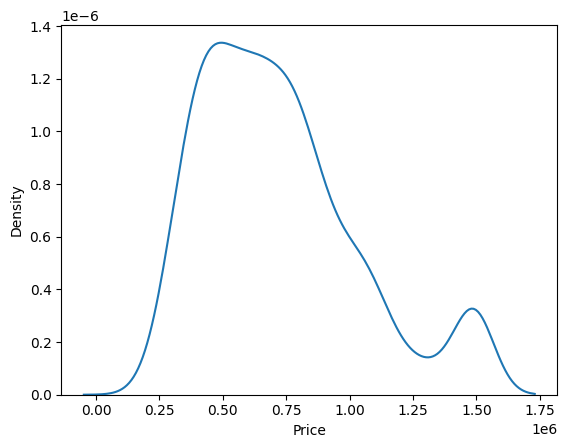

In [11]:
# kernel density plot for Price variable
sns.kdeplot(cdf['Price'])

In [12]:
# summarize Price variable by Make
cdf.groupby('Make')['Price'].describe()

,count,mean,std,min,25%,50%,75%,max
Make,,,,,,,,
Chevrolet,6.0,4.535000e+05,246606.366503,267000.0,288500.00,345500.0,537500.0,892000.0
Datsun,3.0,2.896667e+05,10503.967504,279000.0,284500.00,290000.0,295000.0,300000.0
Ford,52.0,7.211731e+05,140927.699605,290000.0,635000.00,707500.0,787000.0,1066000.0
Honda,73.0,7.983818e+05,264893.305869,316000.0,581000.00,785000.0,915000.0,1493875.0
Hyundai,305.0,6.910783e+05,276437.697587,248000.0,485000.00,638000.0,837000.0,1493875.0
Jeep,4.0,1.442906e+06,101937.500000,1290000.0,1442906.25,1493875.0,1493875.0,1493875.0
Kia,8.0,1.478266e+06,44149.979650,1369000.0,1493875.00,1493875.0,1493875.0,1493875.0
MG Motors,35.0,1.493875e+06,0.000000,1493875.0,1493875.00,1493875.0,1493875.0,1493875.0
Mahindra,18.0,1.100167e+06,175549.305961,796000.0,1037000.00,1094500.0,1157000.0,1465000.0


<ipython-input-13-8f3f838d0e30>:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(cdf, x='Price', hue='Make', common_norm=False, fill=True)


<Axes: xlabel='Price', ylabel='Density'>

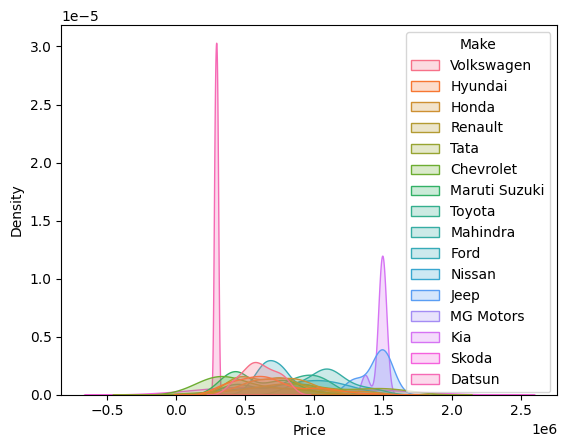

In [13]:
# kernel density plot for Price by Make
sns.kdeplot(cdf, x='Price', hue='Make', common_norm=False, fill=True)

In [14]:
# import from sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

# set X and y
X = cdf[['Mileage_Run']] # chatgpt helped me fix an error by using [[]] instead of []
y = cdf['Price']

# split the dataset into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
TSS = np.sum( (y_test - y_train.mean())**2 )
N_test = len(y_test)

R2: 0.028348174939216708
RMSE: 302171.30217163835


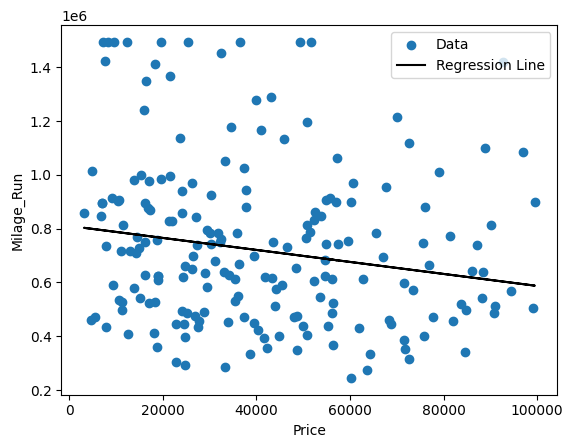

In [15]:
# create linear model from training set and fit to test set
from sklearn.linear_model import LinearRegression
reg_n = LinearRegression().fit(X_train, y_train) # Fit the linear model
y_hat_n = reg_n.predict(X_test)

# get metrics
SSE_n = np.sum((y_test-y_hat_n)**2)
MSE_n = SSE_n/N_test
RMSE_n = np.sqrt(MSE_n)
R2_n = 1 - SSE_n/TSS

# print r2 and rmse values from linear regression
print('R2:', R2_n)
print('RMSE:', RMSE_n)

# plot linear regression
plt.scatter(X_test, y_test, label='Data')
plt.plot(X_test, y_hat_n, label='Regression Line', color='black')
plt.xlabel('Price')
plt.ylabel('Milage_Run')
plt.legend()
plt.show()

In [16]:
# create dataset of categorical variables
categorical = cdf.drop(['Mileage_Run', 'Price'], axis=1)

# one hot encoding
ddf = pd.get_dummies(categorical, dtype='int')

# set X to new dataset after one hot encoding
X_c = ddf

# split dataset again
X_train_c, X_test_c, y_train, y_test = train_test_split(X_c, y, test_size=0.2, random_state=50)

# create linear regression
reg = LinearRegression().fit(X_train_c, y_train)
y_hat_c = reg.predict(X_test_c)

# get metrics
SSE_c = np.sum((y_test - y_hat_c) ** 2)
MSE_c = SSE_c / N_test
RMSE_c = np.sqrt(MSE_c)
R2_c = 1 - SSE_c / TSS

# print r2 and rmse values
print("R2:", R2_c)
print("RMSE:", RMSE_c)

R2: 0.8115376461078132
RMSE: 133079.20149022172


In [17]:
# create a linear regression with both numeric and categorical variables

# create dataset with all columns except Price
X_combined = pd.concat([X, X_c], axis=1)

# split the model
X_train_combined, X_test_combined, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=50)

reg_combined = LinearRegression().fit(X_train_combined, y_train)
y_hat_combined = reg_combined.predict(X_test_combined)

# get metrics
N_test = len(y_test)
SSE_combined = np.sum((y_test - y_hat_combined) ** 2)
MSE_combined = SSE_combined / N_test
RMSE_combined = np.sqrt(MSE_combined)
R2_combined = 1 - SSE_combined / TSS

# print r2 and rmse values
print("R2:", R2_combined)
print("RMSE", RMSE_combined)

R2: 0.8117645621075414
RMSE 132999.06109418772


In [18]:
# the categorical model was better than the numerical model (I considered the Mileage_Run variable as the only numerical value)
# the combined model was better than both the numerical and categorical model
# the combined model is only marginally better than the categorical model

In [19]:
# linear model using polynomial expansion for numeric

# Expand features
expander = PolynomialFeatures(degree=4,include_bias=False) # Create the expander
#
Z_train = expander.fit_transform(X_train) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_train_lm = pd.DataFrame(data=Z_train, columns = names) # Create a new, expanded dataframe
#
Z_test = expander.fit_transform(X_test) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_test_lm = pd.DataFrame(data=Z_test, columns = names) # Create a new, expanded dataframe

# Fit the model and get the R2 measure:
reg_pe = LinearRegression().fit(X_train_lm, y_train) # Fit the linear model
y_hat_pe = reg_pe.predict(X_test_lm)
#print(reg_pe.score(X_test_lm, y_test)) # R squared measure
#rmse_numeric = np.sqrt(mean_squared_error(y_test, y_hat_pe))

N_test = len(y_test)
SSE_pe = np.sum((y_test - y_hat_pe) ** 2)
MSE_pe = SSE_pe / N_test
RMSE_pe = np.sqrt(MSE_pe)
print(RMSE_pe)
R2_pe = 1 - SSE_pe/TSS
print(R2_pe)

300860.79621803295
0.03675793618510781


In [20]:
# linear model using polynomial expansion for categorical

# Expand features
expander = PolynomialFeatures(degree=1,include_bias=False) # Create the expander
#
Z_train = expander.fit_transform(X_train_c) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_train_lm = pd.DataFrame(data=Z_train, columns = names) # Create a new, expanded dataframe
#
Z_test = expander.fit_transform(X_test_c) # Pass the df into the expander to get powers/interactions of x and y
names = expander.get_feature_names_out() # Get the names of these variables
X_test_lm = pd.DataFrame(data=Z_test, columns = names) # Create a new, expanded dataframe

# Fit the model and get the R2 measure:
reg_pe = LinearRegression().fit(X_train_lm, y_train) # Fit the linear model
y_hat_pe = reg_pe.predict(X_test_lm)
#print(reg_pe.score(X_test_lm, y_test)) # R squared measure
#rmse_numeric = np.sqrt(mean_squared_error(y_test, y_hat_pe))

N_test = len(y_test)
SSE_pe = np.sum((y_test - y_hat_pe) ** 2)
MSE_pe = SSE_pe / N_test
RMSE_pe = np.sqrt(MSE_pe)
print(RMSE_pe)
R2_pe = 1 - SSE_pe/TSS
print(R2_pe)

# the only polynomial degree this model is effactive at is degree=1
# at degree=2, the R2 value becomes negative

# the third model from part 4 (combined model) is the best model still
# marginally better than the categorical polynomial expander model at degree=1

133079.20149022172
0.8115376461078132


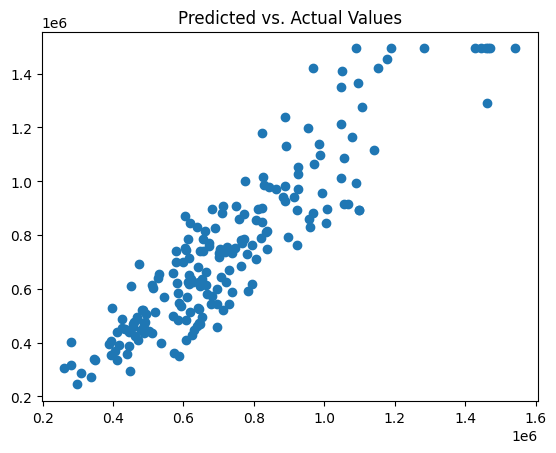

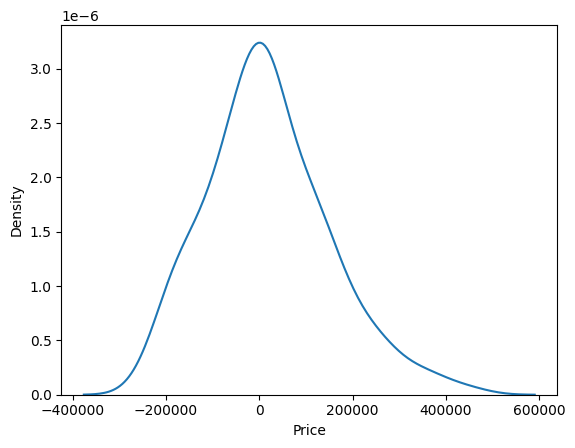

In [21]:
# plotting real vs predicted for best linear regression model
plt.scatter(x=y_hat_combined,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()


# Residual plot:
residuals = y_test - y_hat_combined
sns.kdeplot(residuals)
plt.show()

# the values do roughly line up along the diagonal
# the values align better with lower values than at higher values

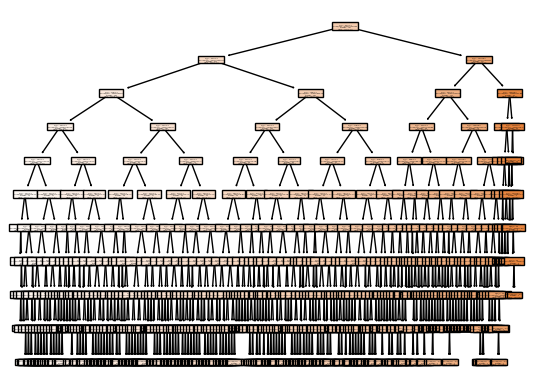

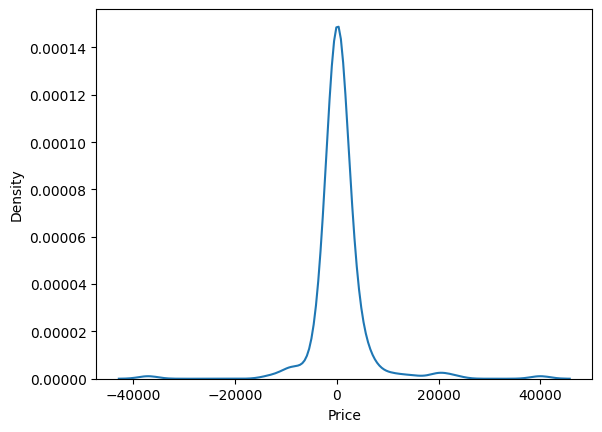

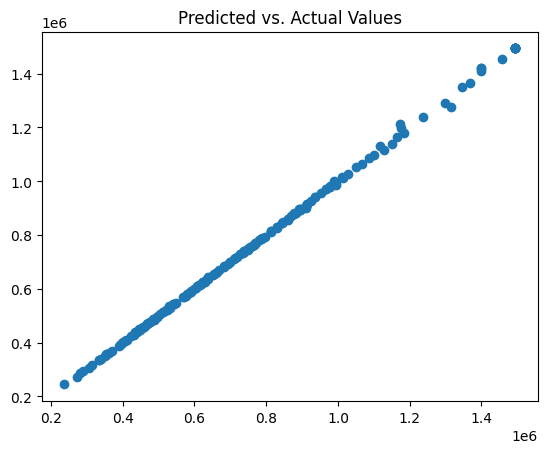

R2:  0.9996732222582043
RMSE:  5541.4588728880135


In [22]:
## Decision Trees sample code:
# import from sklearn
from sklearn import tree

# create dataset of categorical variables
categorical = cdf.drop(['Mileage_Run', 'Price'], axis=1)

# one hot encoding
ddf = pd.get_dummies(categorical, dtype='int')

# set X to new dataset after one hot encoding
X_c = ddf

# create dataset with all columns except Price
X = pd.concat([cdf['Price'], X_c], axis=1)

# set X and y
#X = cdf.drop(['Price'],axis=1) # chatgpt helped me fix an error by using [[]] instead of []
y = cdf['Price']

# split the dataset into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
TSS = np.sum( (y_test - y_train.mean())**2 )
N_test = len(y_test)

model = tree.DecisionTreeRegressor(max_depth=10) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True)
plt.show()

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart

## Residual plot:
sns.kdeplot(residuals_cart)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_cart,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()


## Metrics:
SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/N_test)*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/N_test)**(1/2)
R2_cart = 1 - SSE_cart/TSS
print('R2: ', R2_cart)
print('RMSE: ', RMSE_cart)

# I ran the model for a max depth of 5, 10, and 15. 10 was the tree depth with the best results
# on the kdeplot, the density is bell-shaped around zero'
# on the predicted vs actual graph, the points align nearly perfectly on the diagonal

In [23]:
# the regression tree fits the data better
# the R2 and RMSE values are higher and lower, respectively on the tree

**Q2.** The is a question about regression using decision trees and linear models. The data include wages at data science-y jobs, including

  - `Rating`: Company worker happiness score
  - `Size`: Number of employees
  - `Sector`: Part of the economy
  - `avg_salary`: Average wage
  - `job_state`: Location of work

  1. Load the `wages_hw.csv` file. Split the sample into an ~80% training set and a ~20% test set. Do any necessary cleaning, including outliers and missings.
  2. Use a linear model to regress `avg_salary` on `Sector`. Which sectors have the highest predicted wages? What is the $R^2$ and `RMSE` on the test set?
  3. Make a scatterplot of `avg_salary` and `Rating`. Is there an obvious visual relationship between the two variables? Regress `avg_salary` on `Rating` as a numeric variable: Do higher ratings predict higher or lower wages? Convert `Rating` to a one-hot encoded variable, with a category for each rating. Run a regression of `avg_salary` on the categorical version. How do your results change? Explain. Which version has a higher $R^2$ and lower `RMSE`?
  4. Now interact `Sector` with the categorical version of `Rating`, so your regressors are a (Sector, Rating) pair; this is a programming puzzle you'll have to think about, but using the `.PolynomialFeatures()` function on the one-hot encoded categorical variables is one option, and another is pre-processing a new variable that interacts `Sector` and `Rating` and then one-hot encoding the result. Regress `avg_salary` on the (Sector, Rating) pairs. How does the $R^2$ and `RMSE` on the test set compare to part 2? Interpret the coefficients; which sector-rating pairs have the highest wages?
  5. Run a linear regression of `avg_salary` on all the variables. What is the $R^2$ on the test set? How does it compare to your simpler models in 2--4?
  6. Build a decision tree by regressing `avg_salary` on `Sector`, `Rating`, and the (Sector, Rating) pairs. What are the $R^2$ and `RMSE` of your models on the test set? How do your answers compare to parts 2, 3, and 4?
  7. Build a decision tree by regressing `avg_salary` on all the other variables. What is the $R^2$ and `RMSE` on the test set?
  8. Build a linear regression or decision tree using the available variables based on your own judgment. What degrees of freedom are you giving the model to predict variation in wages across company and location attributes? What is the $R^2$ and `RMSE` of your model? How does it compare to the previous ones in the question? Why does yours perform better or worse on the test set?

In [24]:
wdf = pd.read_csv('assignment4/data/wages_hw.csv')
wdf.head()

,Unnamed: 0,Rating,Size,Sector,avg_salary,job_state
0,1,3.8,501 to 1000 employees,Aerospace & Defense,72.0,NM
1,2,3.4,10000+ employees,Health Care,87.5,MD
2,3,4.8,501 to 1000 employees,Business Services,85.0,FL
3,4,3.8,1001 to 5000 employees,"Oil, Gas, Energy & Utilities",76.5,WA
4,5,2.9,51 to 200 employees,Business Services,114.5,NY


In [25]:
wdf.dropna(inplace=True)
wdf['avg_salary'] = windsorize(wdf['avg_salary'])
wdf['Rating'] = windsorize(wdf['Rating'])

<ipython-input-9-bd4cef2de353>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x < lower_whisker ] = lower_whisker
<ipython-input-9-bd4cef2de353>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_windsor[ x > upper_whisker ] = upper_whisker


In [26]:
# set X and y
W = wdf[['Sector']] # chatgpt helped me fix an error by using [[]] instead of []
Q = wdf['avg_salary']

# one hot encoding
W = pd.get_dummies(Q, dtype='int')

# split the dataset into a training and test set
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(W, Q, test_size=0.2, random_state=50)
TSS_s = np.sum( (y_test_s - y_train_s.mean())**2 )
N_test_s = len(y_test_s)

R2: 0.7323919308611142
RMSE: 19.675992198317143


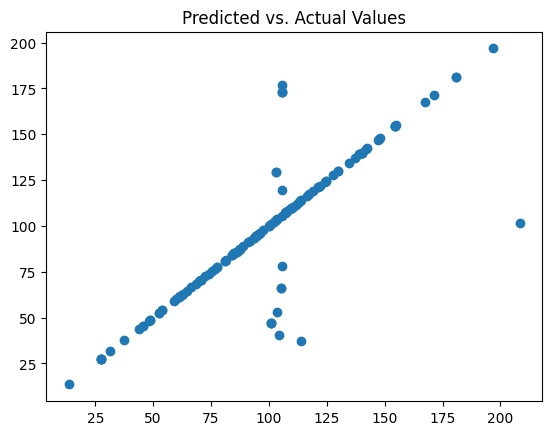

In [27]:
# create linear model from training set and fit to test set

# set X to new dataset after one hot encoding
reg_s = LinearRegression().fit(X_train_s, y_train_s) # Fit the linear model
y_hat_s = reg_s.predict(X_test_s)

# get metrics
SSE_s = np.sum((y_test_s-y_hat_s)**2)
MSE_s = SSE_s/N_test_s
RMSE_s = np.sqrt(MSE_s)
R2_s = 1 - SSE_s/TSS_s

# print r2 and rmse values from linear regression
print('R2:', R2_s)
print('RMSE:', RMSE_s)

plt.scatter(y_hat_s, y_test_s)
plt.title("Predicted vs. Actual Values")
plt.show()

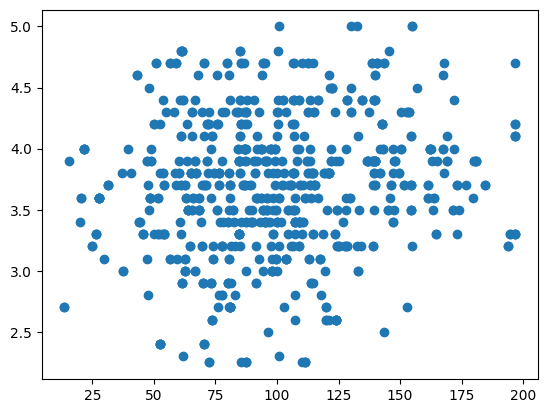

In [28]:
plt.scatter(wdf['avg_salary'],wdf['Rating'])
#there is no obvious linear relationship between avg salary

R2: 0.010627469690594027
RMSE: 0.5003860147070521


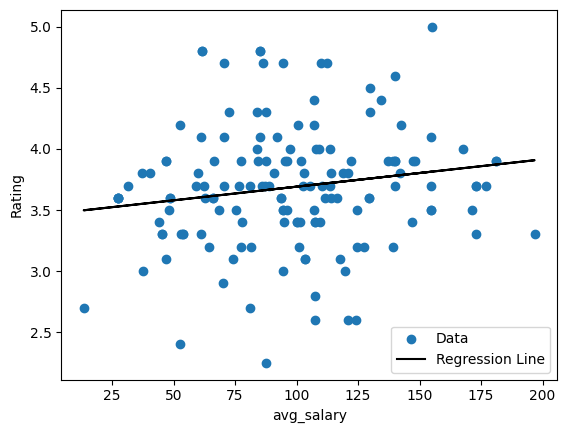

In [29]:
# regress avg salary and rating (numeric)
A = wdf[['avg_salary']]
B = pd.to_numeric(wdf['Rating'])

X_train_rn, X_test_rn, y_train_rn, y_test_rn = train_test_split(A, B, test_size=0.2, random_state=50)
TSS_rn = np.sum( (y_test_rn - y_train_rn.mean())**2 )
N_test_rn = len(y_test_rn)

# set X to new dataset after one hot encoding
reg_rn = LinearRegression().fit(X_train_rn, y_train_rn) # Fit the linear model
y_hat_rn = reg_rn.predict(X_test_rn)

# get metrics
SSE_rn = np.sum((y_test_rn-y_hat_rn)**2)
MSE_rn = SSE_rn/N_test_rn
RMSE_rn = np.sqrt(MSE_rn)
R2_rn = 1 - SSE_rn/TSS_rn

# print r2 and rmse values from linear regression
print('R2:', R2_rn)
print('RMSE:', RMSE_rn)

# plot linear regression
plt.scatter(X_test_rn, y_test_rn, label='Data')
plt.plot(X_test_rn, y_hat_rn, label='Regression Line', color='black')
plt.xlabel('avg_salary')
plt.ylabel('Rating')
plt.legend()
plt.show()

# higher ratings are positively related to higher salaries

In [41]:
# regress avg salary and rating (categorical)
C = wdf[['avg_salary']]
D = pd.get_dummies(wdf['Rating'], dtype='int', drop_first=True)

X_train_rc, X_test_rc, y_train_rc, y_test_rc = train_test_split(C, D, test_size=0.2, random_state=50)
TSS_rc = np.sum( (y_test_rc - y_train_rc.mean())**2 )
N_test_rc = len(y_test_rc)

D = pd.concat([D, pd.Series(1, index=wdf.index, name='Intercept')], axis=1)

# set X to new dataset after one hot encoding
reg_rc = LinearRegression().fit(X_train_rc, y_train_rc) # Fit the linear model
y_hat_rc = reg_rc.predict(X_test_rc)

# Get the coefficients, including the intercept
coefficients = reg_rc.coef_
intercept = reg_rc.intercept_

# get metrics
SSE_rc = np.sum((y_test_rc-y_hat_rc)**2)
MSE_rc = SSE_rc/N_test_rc
RMSE_rc = np.sqrt(MSE_rc)
R2_rc = 1 - SSE_rc/TSS_rc

# print r2 and rmse values from linear regression
print('R2: ', np.mean(R2_rc))
print('RMSE:', np.mean(RMSE_rc))

# worked better as a numeric variable (higher R2 but also higher rsme)

R2:  -0.019255528743038243
RMSE: 0.1640773769076884


In [44]:
E = wdf['Sector']
E = pd.get_dummies((E), dtype='int', drop_first=True)
F = wdf['Rating']
F = pd.get_dummies((F), dtype='int', drop_first=True)

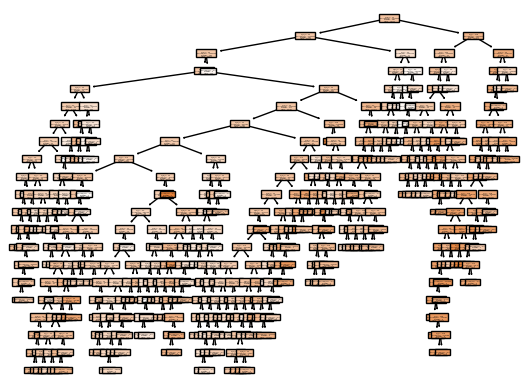

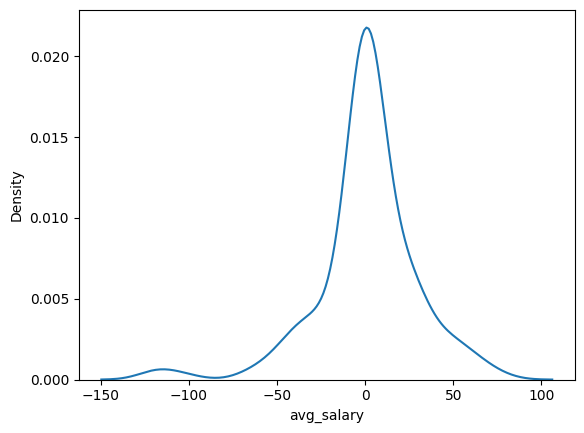

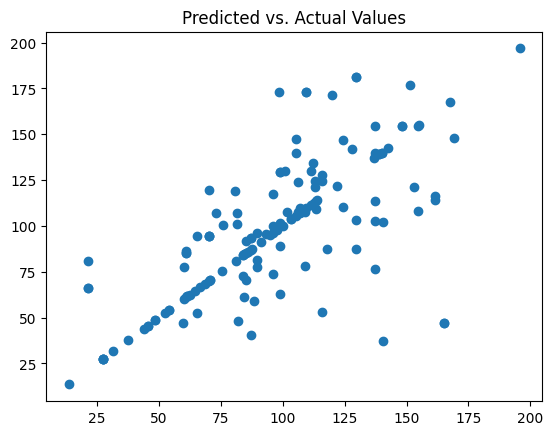

R2:  0.4370425160068897
RMSE:  28.538085709787165


In [53]:
## Decision Trees sample code:
# import from sklearn
from sklearn import tree

# create dataset of categorical variables
categorical = wdf[['Size', 'Sector', 'job_state']]

# one hot encoding
ddf = pd.get_dummies(categorical, dtype='int')
# set X to new dataset after one hot encoding
X_c = ddf

# create dataset with all columns except Price
X = pd.concat([wdf['Rating'], X_c], axis=1)

# set X and y
#X = cdf.drop(['Price'],axis=1) # chatgpt helped me fix an error by using [[]] instead of []
y = wdf['avg_salary']

# split the dataset into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
TSS = np.sum( (y_test - y_train.mean())**2 )
N_test = len(y_test)

model = tree.DecisionTreeRegressor(max_depth=20) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True)
plt.show()

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart

## Residual plot:
sns.kdeplot(residuals_cart)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_cart,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()


## Metrics:
SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/N_test)*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/N_test)**(1/2)
R2_cart = 1 - SSE_cart/TSS
print('R2: ', R2_cart)
print('RMSE: ', RMSE_cart)

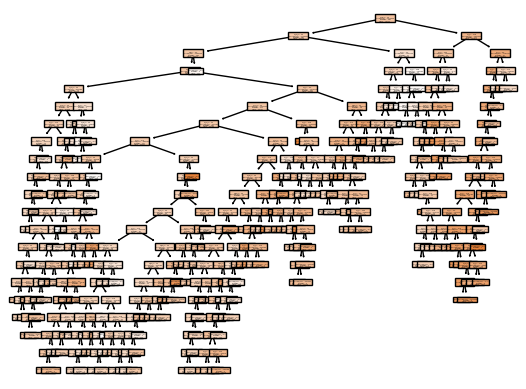

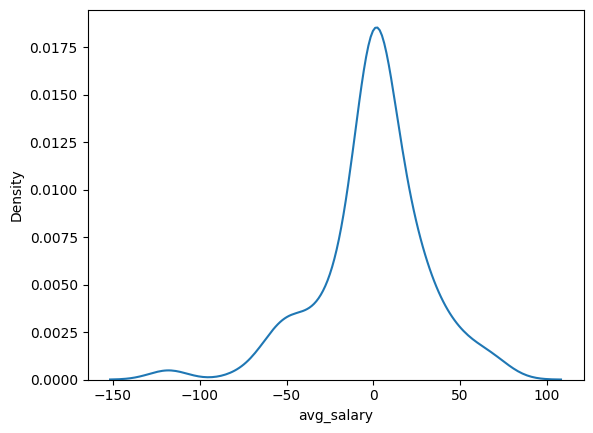

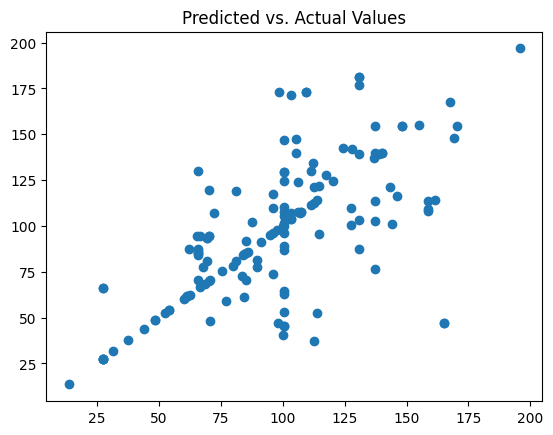

R2:  0.36361575027097415
RMSE:  30.342177923167583


In [60]:
## Decision Trees sample code:
# import from sklearn
from sklearn import tree

# create dataset of categorical variables
categorical = wdf[['Sector', 'job_state']]

# one hot encoding
ddf = pd.get_dummies(categorical, dtype='int')
# set X to new dataset after one hot encoding
X_c = ddf

# create dataset with all columns except Price
X = pd.concat([wdf['Rating'], X_c], axis=1)

# set X and y
#X = cdf.drop(['Price'],axis=1) # chatgpt helped me fix an error by using [[]] instead of []
y = wdf['avg_salary']

# split the dataset into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)
TSS = np.sum( (y_test - y_train.mean())**2 )
N_test = len(y_test)

model = tree.DecisionTreeRegressor(max_depth=20) # Fit the classifier
cart = model.fit(X_train, y_train)
tree.plot_tree(cart,filled=True)
plt.show()

## Make Predictions on the Test Set
y_hat_cart = cart.predict(X_test)
residuals_cart = y_test - y_hat_cart

## Residual plot:
sns.kdeplot(residuals_cart)
plt.show()

## True versus predicted plot:
plt.scatter(x=y_hat_cart,y=y_test)
plt.title('Predicted vs. Actual Values')
plt.show()


## Metrics:
SSE_cart = np.sum( (y_test-y_hat_cart)**2 )
MSE_cart = (1/N_test)*np.sum( (y_test-y_hat_cart)**2 )
RMSE_cart = (SSE_cart/N_test)**(1/2)
R2_cart = 1 - SSE_cart/TSS
print('R2: ', R2_cart)
print('RMSE: ', RMSE_cart)


# i thought out of all the variables in the dataset, i figured size would be the least important
# and would not have a meaningful impact but it did
# so it decreased my r2 value and made my rmse value higher

**Q3.** This a question purely on categorical prediction. The data for this happen to be gathered in 1987 in Indonesia, and concern contraceptive method choice. The questions and data-gathering assumptions reflect the culture and attitudes of that time and place, but provide a good example of a categorical prediction problem on an important topic (family planning and maternal health The variables in the data are:

    - Wife's age (numerical)
    - Wife's education (categorical) 1=low, 2, 3, 4=high
    - Husband's education (categorical) 1=low, 2, 3, 4=high
    - Number of children ever born (numerical)
    - Wife's religion (binary) 0=Non-Islam, 1=Islam
    - Wife's now working? (binary) 0=Yes, 1=No
    - Husband's occupation (categorical) 1, 2, 3, 4
    - Standard-of-living index (categorical) 1=low, 2, 3, 4=high
    - Media exposure (binary) 0=Good, 1=Not good
    - Contraceptive method used (class attribute) 1=No-use, 2=Long-term, 3=Short-termhort-term

  1. Load the `contraceptiveMethodChoice.csv` data. Tabulate the `method` variable (i.e. `.value_counts()`). 1 corresponds to `No Contraception`, 3 corresponds to `Short Term` (e.g. condoms, birth control pills), and 2 corresponds to `Long Term` (e.g. IUD, sterilization). Cross tabulate `method` and `numberChildren`. Do couples that use birth control tend to have more children than those who don't?
  2. Split the sample into ~80% training data and ~20% testing data.
  3. We are now going to make a mistake. Train a regression tree to predict the contraceptive method using the other variables in the data, not a classification tree. Look at the terminal nodes in the tree: What values do they take? Does that make sense? Explain clearly what has gone wrong here.
  4. Instead of regression, use a classification tree to predict contraceptive method using the other variables in the data. How does it look different from the previous tree? What variables does the algorithm use? In broad terms, which groups of people are most likely to use each method of contraception?
  5. Compute a confusion matrix for your classification tree on the test set (Hint: There are now three categories instead of two, so the cross tabulation will be a $3 \times 3$ matrix instead of $2 \times 2$.). Compute the Accuracy of your model overall, and the Accuracy for predicting each contraceptive method.
  7. Why can't you use a linear probability model to do this exercise? Explain clearly in words.

**Q4.** This is a question where we use regression and regression trees. The outcome is whether a defendant is held pre-trial in the Virginia justice system. We would like to understand how that outcome is predicted by characteristics of the defendant, particularly race. Let's be very careful/clear: We aren't saying anyone *should* be held without bond or asserting that people with different demographic variables *should* be more likely to be held, but instead trying to predict whether people with different characteristics *are empirically more likely* to be held without bond, given the available information. This is the first step we would take in investigating whether a system is fair, or how large the disparities are: Does it treat people with similar observable characteristics similarly, or not? We are going to look at a common question: Are Black defendants treated differently from white or Asian ones? (There are Native American defendants, but there are 11 in total, which is such a small number of observations that is difficult to clearly say anything about how this group is treated relative to the others.)

The variables in the data are:

  - `held_wo_bail`: Whether a defendant is held without bail before trial (Boolean logical)
  - `race`, `sex`: Categorical demographic variables
  - `is_poor`: Whether the defendant is classified as indigent
  - `prior_F`, `prior_M`: The number of prior felony and misdemeanor arrests
  - `case_type`: A categorical variable indicating a misdemeanor `M` or felony `F` or infraction `I` or special case `S`
  - `age`: Defendant's age
  - `bond`, `bond_NA`, `bond_type`: The amount of any bond, whether it is missing, and the type
  - `sentence`, `sentence_NA`, `sentence_type`: The length of any sentence, whether it is missing, and the type

1. Load the `pretrial_data.csv` data. Notice that there are `nan`s, but the data are relatively clean. Because there are `.nan`s among variables you won't use, you'll want to narrow down your analysis to the relevant variables before dropping or imputing missing values.
2. Create a dummy variable indicating that the defendant is Black.
3. Regress `held` on `Black`. What is the slope coefficient Interpret the coefficient on the Black dummy variable: How much more likely is a black person to be held without bail? What is the $R^2$ of the model?
4. Before doing this question, please think for a few minutes about how to make the process of running these regressions as efficient as possible, before jumping into writing code. Repeat part 2, for the following specifications, keeping track of the coefficient on the Black dummy variable each time:
      - `held` on `Black` and `sex`
      - `held` on `Black` and `sex` and `is_poor`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F`
      - `held` on `Black` and `sex` and `is_poor` and `prior_F` and `case_type`
What happens to the coefficient on the Black dummy variable as you include more regressors/features/controls in the regression? Explain your findings.
5. Suppose we don't want to see just `Black` and `sex`, but `Black` interacted with `sex`: Are Black men and Black women treated systemically differently from the rest of the population? Implement this in a regression, and explain your findings.
6. Imagine someone argued we should use these kinds of models to help a judge or magistrate make bail decisions (you could obviously go back and make this kind of model for the bond and sentence variables, then deploy it on new cases to predict what their bond and sentence values would be). What concerns would you have? Do you think society should be using data-driven and automated tools like that? Explain your concerns clearly.

**Q5.** This is a math question to review the derivation of the OLS estimator (but only if you are into that kind of thing!). We are going to do it slightly differently from what we did in class, though. We will use a linear predictor and minimize the Sum of Squared Errors, just as in class. But, we are going to de-mean $X$ first, creating another variable $z_i = x_i - \bar{x}$ where
$$
\bar{x} = \dfrac{1}{N} \sum_{i=1}^N x_i,
$$
so the model is $\hat{y}_i = a + b z_i$ and the `SSE` is
$$
\text{SSE}(a,b) = \sum_{i=1}^N (y_i - a - bz_i)^2.
$$

  1. Take partial derivatives of the `SSE` with respect to $a$ and $b$. You should get

\begin{eqnarray*}
\sum_{i=1}^N -2(y_i - a- bz_i) &=& 0 \\
\sum_{i=1}^N -2(y_i - a - bz_i)z_i &=& 0.
\end{eqnarray*}

  2. Solve for the solutions to the above equations. Big hint: $\bar{z} = 0$, since we subtracted the mean of $x$ from $x$ to get $z$. You should get

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})z_i}{\sum_{i=1}^N z_i^2}.
\end{eqnarray*}

  3. Substitute $z_i = x_i - \bar{x}$ back into the above equations. You should get
  
\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\sum_{i=1}^N(y_i - \bar{y})(x_i-\bar{x})}{\sum_{i=1}^N (x_i-\bar{x})^2},
\end{eqnarray*}

which can be written in terms of sample covariance and sample variance as:

\begin{eqnarray*}
a^* &=& \bar{y} \\
b^* &=& \dfrac{\text{cov}(x,y)}{\text{var}(x)}.
\end{eqnarray*}

This is typically the preferred way of expressing the OLS coefficients.

4. When will $b^*$ be large or small, depending on the relationship between $x$ and $y$ and the amount of "noise"/variance in $x$? What does $a^*$ represent?
5. Suppose you have measurement error in $x$ which artificially inflates its variance (e.g. bad data cleaning). What happens to the $b^*$ coefficient? How will affect your ability to predict? (This phenomenon is called **attenuation**.)
6. Let's return to the question of *outliers*. With your formula for the OLS coefficients $(a^*,b^*)$, explain what happens if you significantly increase a single value of the outcome/target/response variable $y_i$ or one of the predictor/explanatory/covariate variables $x_i$. If values for some extreme observations are exerting significant influence over the regression coefficients, will the model perform well on for more average observations?